In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [53]:
data = pd.read_excel('data.xlsx')
load_history = data['Нагрузка']
load_history_np = load_history.to_numpy().reshape(-1, 24)

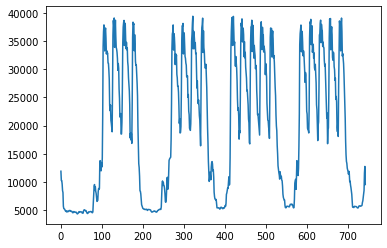

In [54]:
plt.plot(load_history)

In [55]:
prices_with_components = pd.read_excel('prices.xlsx')
prices_with_components = prices_with_components.drop(axis = 1, index = [0])
prices_total = []
for i in range(0, 31):
  prices_total += [prices_with_components.iloc[i*5].to_numpy()[1:]]
prices_total = np.array(prices_total)

In [56]:
work_days = [6, 7, 8, 12, 13, 14, 15, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29]
peak_hours = [21, 21, 21, 21, 11, 21, 11, 15, 11, 21, 12, 14, 11, 11, 11, 11, 14]
pchpn = [8, 9, 10, 11, 12, 13, 14, 15, 20, 21]

In [57]:
expenses_energy = np.sum(prices_total * load_history_np) / 1000

In [58]:
peak_loads = []
for day, hour in zip(work_days, peak_hours):
  peak_loads += [load_history_np[day - 1][hour - 1]]

In [59]:
expenses_power = np.mean(peak_loads) * 940879.77 / 1000

In [60]:
peak_transmission = []
for day in work_days:
  loads_pchpn = []
  for hour in pchpn:
    loads_pchpn += [load_history_np[day - 1][hour - 1]]
  peak_transmission += [np.max(loads_pchpn)]

In [61]:
expenses_transmission = np.mean(peak_transmission) * 948820.42 / 1000

In [62]:
total_expenses = expenses_energy + expenses_power + expenses_transmission

In [63]:
peak_loads = []
peak_loads_mask = []
count = 0
for i in range(load_history_np.shape[0]):
  if i+1 in work_days:
    work_day = np.zeros(24)
    work_day_mask = np.zeros(24)
    work_day[peak_hours[count]-1] = load_history_np[i][peak_hours[count]-1]
    work_day_mask[peak_hours[count]-1] = 1
    peak_loads += [work_day]
    peak_loads_mask += [work_day_mask]
    count += 1
  else:
    peak_loads += [np.zeros(24)]
    peak_loads_mask += [np.zeros(24)]
peak_loads = np.array(peak_loads)
peak_loads_mask = np.array(peak_loads_mask)

pchpn_loads = []
pchpn_loads_mask = []
for i in range(load_history_np.shape[0]):
  if i+1 in work_days:
    work_day = np.zeros(24)
    work_day_mask = np.zeros(24)
    work_day[7:15] = load_history_np[i][7:15]
    work_day_mask[7:15] = 1
    work_day[19:21] = load_history_np[i][19:21]
    work_day_mask[19:21] = 1
    pchpn_loads += [work_day]
    pchpn_loads_mask += [work_day_mask]
  else:
    pchpn_loads += [np.zeros(24)]
    pchpn_loads_mask += [np.zeros(24)]
pchpn_loads = np.array(pchpn_loads)
pchpn_loads_mask = np.array(pchpn_loads_mask)

holidays_mask = np.zeros(24*31)
holidays_mask[0:5 * 24] = 1
holidays_mask[8 * 24:11 * 24] = 1
holidays_mask[15 * 24:17 * 24] = 1
holidays_mask[22 * 24:24 * 24] = 1
holidays_mask[29 * 24:31 * 24] = 1

In [64]:
DR = 0 # (учитываем ли управление спросом)
r = 0.0
x = cp.Variable(24*31)
v = cp.Variable(24*31)

In [65]:
# Целевая функция
def func_month():
  load_corrected = load_history_np.reshape(-1) + x
 
  peak_loads_corrected = cp.multiply((peak_loads.reshape(-1) + x), peak_loads_mask.reshape(-1))
  
  pchpn_loads_corrected = cp.multiply((pchpn_loads.reshape(-1) + x),  pchpn_loads_mask.reshape(-1))

  return cp.sum(cp.multiply(prices_total.reshape(-1) , load_corrected)) / 1000 , cp.sum(peak_loads_corrected) / len(work_days) * 940879.77 / 1000 , cp.sum(cp.max(cp.atoms.affine.reshape.reshape(pchpn_loads_corrected, (31, 24) ), axis = 1)) / len(work_days) * 948820.42 / 1000

In [66]:
def get_results(DR = 0, r = 0.0):
  objective = cp.Minimize(func_month()[0] + func_month()[1] + func_month()[2])
  constraints = [cp.abs(x) <=4000,
                   cp.multiply(x , holidays_mask) == 0, 
                   x[14*24+12:14*24+16] == -3600 * DR, 
                   x[28*24+10:28*24+14] == -3600 * DR, 
                   x >= (-(cp.cumsum(x) - x) * (1 - r)), 
                   x <= ((16000 - (cp.cumsum(x) - x)) / (1 - r))]
  prob = cp.Problem(objective, constraints)  
  result = prob.solve()

  plt.figure(figsize = (35,10))
  plt.plot(load_history_np.reshape(-1))
  plt.plot(load_history_np.reshape(-1)+x.value)
  plt.xlabel('Час')
  plt.ylabel('кВт')
  return load_history_np.reshape(-1)+x.value

In [67]:
def func_for_plot(a = True):
  if a:
    load_corrected = load_history_np.reshape(-1) + x.value
    peak_loads_corrected = np.multiply((peak_loads.reshape(-1) + x.value), peak_loads_mask.reshape(-1))
    pchpn_loads_corrected = np.multiply((pchpn_loads.reshape(-1) + x.value),  pchpn_loads_mask.reshape(-1))

  else:
    load_corrected = load_history_np.reshape(-1)
    peak_loads_corrected = peak_loads.reshape(-1)
    pchpn_loads_corrected = pchpn_loads.reshape(-1)

  return np.sum(np.multiply(prices_total.reshape(-1) , load_corrected)) / 1000 , np.sum(peak_loads_corrected) / 17 * 940879.77 / 1000 , np.sum(np.max(pchpn_loads_corrected.reshape(31, 24) , axis = 1)) / 17 * 948820.42 / 1000

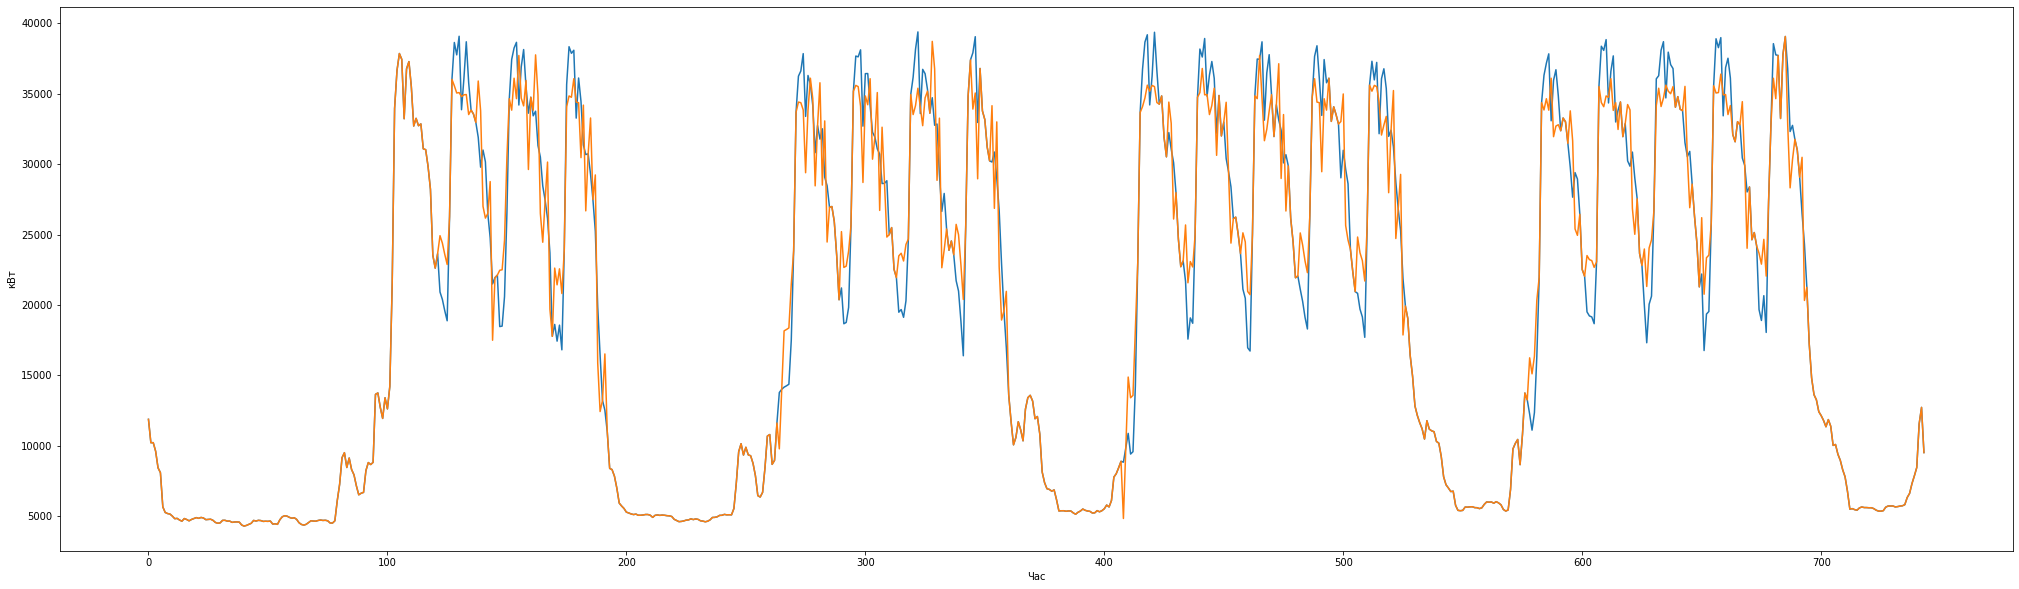

In [68]:
# График за месяц с учетом управления СНЭ
optimized_profile = get_results()

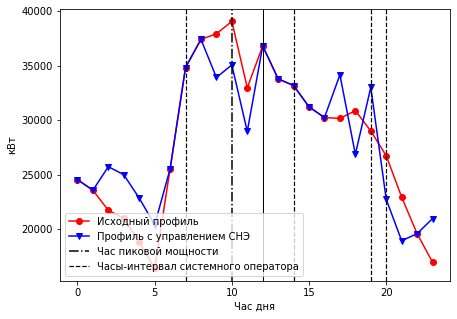

In [69]:
plt.figure(figsize = (7,5))
plt.plot(load_history_np.reshape(-1)[14*24:15*24], 'ro', ls = '-')
plt.plot(load_history_np.reshape(-1)[14*24:15*24]+x.value[14*24:15*24], 'bv', ls = '-')
plt.xlabel('Час дня')
plt.ylabel('кВт')

plt.axvline(10, ls = '-.', c = 'k')
plt.axvline(7, ls = '--', c = 'k', lw = 1.2)
plt.axvline(12, ls = '-', c = 'k', lw = 1)

plt.axvline(14, ls = '--', c = 'k', lw = 1.2)
plt.axvline(19, ls = '--', c = 'k', lw = 1.2)
plt.axvline(20, ls = '--', c = 'k', lw = 1.2)
plt.legend(('Исходный профиль', 'Профиль с управлением СНЭ', 'Час пиковой мощности', 'Часы-интервал системного оператора'))
plt.savefig('corrected_storage.svg', format='svg', dpi=10000)

In [70]:
a = func_for_plot(a = True)
b = func_for_plot(a = False)
print('Затраты с учетом управления СНЭ: Энергия:', a[0], 'Покупная мощность:', a[1], 'Сетевая мощность:',a[2], 'Итого:', a[0]+a[1]+a[2]- DR * 270000)
print('Исходные затраты: Энергия:', b[0], 'Покупная мощность:', b[1], 'Сетевая мощность:',b[2], 'Итого:', b[0]+b[1]+b[2])
print('Экономия: Энергия:', b[0] - a[0], 'Покупная мощность:', b[1] - a[1], 'Сетевая мощность:', b[2] - a[2], 'Итого:', - a[0] + b[0] - a[1] + b[1] - a[2] + b[2] + DR * 270000)

Затраты с учетом управления СНЭ: Энергия: 21414658.609476306 Покупная мощность: 28938196.32346993 Сетевая мощность: 34604206.22136824 Итого: 84957061.15431447
Исходные затраты: Энергия: 21650801.441380005 Покупная мощность: 32306269.166195296 Сетевая мощность: 36655835.09882588 Итого: 90612905.70640117
Экономия: Энергия: 236142.8319036998 Покупная мощность: 3368072.8427253664 Сетевая мощность: 2051628.877457641 Итого: 5655844.552086707
